In [75]:
import polars as pl
from src.paths import (
    PYTHON_VULNERABILITY_FIXES_DATA_PATH,
    PYTHON_CODE_FIXES_DATA_PATH,
    PYTHON_CODE_FIXES_WITH_CONTEXT_DATA_PATH,
    PYTHON_CODE_UNITS_DATA_PATH,
    PYTHON_CODE_CONTEXT_DATA_PATH,
)
from tqdm import tqdm
import jedi
from git import Repo
from typing import Any
import jedi.api
import jedi.common
import json
import shutil
import logging
import matplotlib.pyplot as plt
import tempfile
import subprocess
from pathlib import Path
import json

from src.process_code_changes import get_changes

## Filter out data

In [76]:
# python_commit_data = commit_data_only_top_langs.filter(pl.col("language") == "Python")
python_vulnerability_fixes = pl.read_parquet(PYTHON_VULNERABILITY_FIXES_DATA_PATH)
print(python_vulnerability_fixes.unique("vulnerability_id").shape[0])
python_vulnerability_fixes = python_vulnerability_fixes.group_by('vulnerability_id', 'repo', 'commit', 'pull_request_number', 'file', 'patch', 'patch_time', 'commit_source', 'file_extension', 'language').agg(pl.col("cwe_id"))
python_vulnerability_fixes = python_vulnerability_fixes.unique("patch")
print(python_vulnerability_fixes.unique("vulnerability_id").shape[0])


1560
1556


## Filter out data connected with test functionallity

In [77]:
python_vulnerability_fixes = python_vulnerability_fixes.filter(
    (
        pl.col("file").str.contains(r"\/{0,1}[tT][eE][sS][tT][sS]{0,1}\/")
        | pl.col("patch").str.contains("pytest")
        | pl.col("patch").str.contains("unittest")
    ).not_()
)
python_vulnerability_fixes.unique("vulnerability_id").shape[0]

1550

In [78]:
exclude_langs = [
    "txt",
    "md",
    "JSON",
    "YAML",
    "bugfix",
    "cfg",
    "rst",
    "toml",
    "lock",
    "ini",
    "in",
    "gitignore",
    "sample",
    "pem",
    "feature",
    "tif",
    "security",
    "proto",
    "conf",
    "spec",
    "bin",
    "misc",
    "pyi",
    "pxi",
    "fli",
    "gif",
    "tpl",
    "graphql",
    "http",
    "sgi",
    "pyx",
    "inc"
]
python_vulnerability_fixes = python_vulnerability_fixes.filter(
    (
        pl.col("file").str.split(".").list.last().is_in(exclude_langs)
    ).not_(),
    pl.col("file").str.contains(r"__.*__.py").not_()
)
python_vulnerability_fixes.unique("vulnerability_id").shape[0]

1506

## Process missing commit

In [79]:
print(python_vulnerability_fixes.filter(pl.col("commit").is_null()))
python_vulnerability_fixes = python_vulnerability_fixes.with_columns(
    pl.when(pl.col("pull_request_number") == 24391)
    .then(pl.lit("86664c9405136a4904775c52e6caf100a474ec58"))
    .otherwise(pl.col("commit"))
    .alias("commit")
)
print(python_vulnerability_fixes.filter(pl.col("commit").is_null()))
# No changes related to python: https://github.com/pyca/pyopenssl/commit/6bbf44a00b35fb28df1f66aa194b2fe95eab1ab2
# Very big change: https://github.com/transifex/transifex-client/commit/e0d1f8b38ec1a24e2999d63420554d8393206f58
python_vulnerability_fixes = python_vulnerability_fixes.filter(
    ~pl.col("commit").is_in(
        [
            "6bbf44a00b35fb28df1f66aa194b2fe95eab1ab2",
            "e0d1f8b38ec1a24e2999d63420554d8393206f58",
            "5f7496481bd3db1d06a2d2e62c0dce960a1fe12b",
            # Not exists in repo
            "13336272e32872247fa7d17e964ccd88ec8d1376",
            "2bfe358043096fdba9e2a4cf0f5740102b37fd8f",
        ]
    )
)
python_vulnerability_fixes = python_vulnerability_fixes.filter(
    pl.col("file") != "setup.py"
)
print(python_vulnerability_fixes.filter(pl.col("commit").is_null()))

shape: (32, 11)
┌────────────┬────────────┬────────┬────────────┬───┬───────────┬───────────┬──────────┬───────────┐
│ vulnerabil ┆ repo       ┆ commit ┆ pull_reque ┆ … ┆ commit_so ┆ file_exte ┆ language ┆ cwe_id    │
│ ity_id     ┆ ---        ┆ ---    ┆ st_number  ┆   ┆ urce      ┆ nsion     ┆ ---      ┆ ---       │
│ ---        ┆ str        ┆ str    ┆ ---        ┆   ┆ ---       ┆ ---       ┆ str      ┆ list[str] │
│ str        ┆            ┆        ┆ i64        ┆   ┆ str       ┆ str       ┆          ┆           │
╞════════════╪════════════╪════════╪════════════╪═══╪═══════════╪═══════════╪══════════╪═══════════╡
│ 2014-3146  ┆ lxml/lxml  ┆ null   ┆ 273        ┆ … ┆ github    ┆ py        ┆ Python   ┆ ["CWE-79" │
│            ┆            ┆        ┆            ┆   ┆           ┆           ┆          ┆ ]         │
│ 2014-8991  ┆ pypa/pip   ┆ null   ┆ 2122       ┆ … ┆ github    ┆ py        ┆ Python   ┆ [null]    │
│ 2013-1629  ┆ pypa/pip   ┆ null   ┆ 791        ┆ … ┆ github    ┆ py       

In [81]:
python_vulnerability_fixes.filter(pl.col("vulnerability_id") == "2022-29198").unique("language")

vulnerability_id,repo,commit,pull_request_number,file,patch,patch_time,commit_source,file_extension,language,cwe_id
str,str,str,i64,str,str,"datetime[μs, UTC]",str,str,str,list[str]
"""2022-29198""","""tensorflow/tensorflow""","""ea50a40e84f6bff15a0912728e35b6…",null,"""tensorflow/core/kernels/sparse…","""@@ -67,6 +67,13 @@ class Spars…",2022-05-02 23:16:54 UTC,"""github""","""cc""","""C/C++""","[""CWE-20""]"


In [82]:
if PYTHON_CODE_FIXES_DATA_PATH.exists():
    print("Reading code fixes")
    code_unit_changes = pl.read_parquet(PYTHON_CODE_FIXES_DATA_PATH).to_dicts()
else:
    code_unit_changes: list[dict[str, Any]] = []

repos: dict[str, Repo] = {}

grouped_vulnerabilities = (
    python_vulnerability_fixes.group_by(
        "repo", "vulnerability_id", "commit", "commit_source", "cwe_id"
    )
    .agg(pl.col("patch"), pl.col("file"), pl.col("language"))
    .sample(fraction=1, shuffle=True)
)
errors: list[dict[str, Any]] = []
checked_commits = set([change["commit"] for change in code_unit_changes])


vulnerabilities_to_check = grouped_vulnerabilities.to_dicts()


for commit_data_row in tqdm(vulnerabilities_to_check):
    if commit_data_row["commit"] in checked_commits:
        continue
    try:
        get_changes(commit_data_row)
    except Exception as e:
        logging.exception(f"Error in {commit_data_row}")

Reading code fixes


  0%|          | 0/1800 [00:00<?, ?it/s]ERROR:src.process_code_changes:Error processing commit c4f81d9616d40c60584e36abb15300853a66e489
ERROR:src.process_code_changes:{'repo': 'opengeos/streamlit-geospatial', 'vulnerability_id': '2024-41117', 'commit': 'c4f81d9616d40c60584e36abb15300853a66e489', 'commit_source': 'github', 'cwe_id': ['CWE-20'], 'patch': ['@@ -1,4 +1,5 @@\n import ee\n+import json\n import os\n import warnings\n import datetime\n@@ -377,7 +378,9 @@ def app():\n                         st.write(\n                             cm.plot_colormap(cmap=palette_options, return_fig=True)\n                         )\n-                        st.session_state["palette"] = eval(palette)\n+                        st.session_state["palette"] = json.loads(\n+                            palette.replace("\'", \'"\')\n+                        )\n \n                     if bands:\n                         vis_params = st.text_area(\n@@ -392,7 +395,9 @@ def app():\n                         

In [83]:
new_code_unit_changes = []
new_code_context_changes = []

for commit_data_file in PYTHON_CODE_UNITS_DATA_PATH.rglob("*.json"):
    try:
        with commit_data_file.open() as f:
            new_code_unit_changes.append(json.load(f))
    except:
        print(commit_data_file)
        commit_data_file.unlink()
for commit_data_file in PYTHON_CODE_CONTEXT_DATA_PATH.rglob("*.json"):
    try:
        with commit_data_file.open() as f:
            new_code_context_changes.append(json.load(f))
    except:
        print(commit_data_file)
        commit_data_file.unlink()

pl.DataFrame(new_code_unit_changes).write_parquet(PYTHON_CODE_FIXES_DATA_PATH)
pl.DataFrame(new_code_context_changes).write_parquet(PYTHON_CODE_FIXES_WITH_CONTEXT_DATA_PATH)

In [115]:
pl.read_parquet(PYTHON_CODE_FIXES_DATA_PATH).unique("vulnerability_id").shape[0] / grouped_vulnerabilities.unique("vulnerability_id").shape[0]

1.1140939597315436

## Data cleaning

In [85]:
code_unit_changes_df = pl.read_parquet(PYTHON_CODE_FIXES_DATA_PATH)
code_unit_changes_df = code_unit_changes_df.filter(
    # pl.col("vulnerability_id").is_in(excluded_vulns).not_(),
    pl.col("new_file") != "setup.py",
    pl.col("old_file") != "setup.py"
).with_columns(
    pl.col("code_unit_after_fix").str.replace_all(r"\n\s*\n", "\n").str.strip_chars(),
    pl.col("code_unit_before_fix").str.replace_all(r"\n\s*\n", "\n").str.strip_chars(),
)
code_unit_changes_df.describe()

statistic,commit,repo,new_file,patch,code_unit_after_fix,vulnerability_id,cwe_id,old_file,code_unit_before_fix
str,str,str,str,str,str,str,f64,str,str
"""count""","""4401""","""4401""","""4401""","""4401""","""4401""","""4401""",4401.0,"""4401""","""4401"""
"""null_count""","""0""","""0""","""0""","""0""","""0""","""0""",0.0,"""0""","""0"""
"""mean""",null,null,null,null,null,null,null,null,null
"""std""",null,null,null,null,null,null,null,null,null
"""min""","""001b0634cd309e372edb6d7d95d083…","""389ds/389-ds-base""",""".devcontainer/library-scripts/…","""@@ -1 +1 @@ -__version__ = ""1.…","""""","""2013-0208""",null,""".devcontainer/library-scripts/…",""""""
"""25%""",null,null,null,null,null,null,null,null,null
"""50%""",null,null,null,null,null,null,null,null,null
"""75%""",null,null,null,null,null,null,null,null,null
"""max""","""ffc095a3e5acc1c404773a0510e6d0…","""zwczou/weixin-python""","""zproject/urls.py""","""@@ -99,7 +99,9 @@ extern ""C"" {…","""} else { actionsTempla…","""GHSA-x563-6hqv-26mr""",null,"""zproject/urls.py""","""}, ""scope"": { …"


In [86]:
code_unit_changes_df = code_unit_changes_df.filter(
    ((pl.col("code_unit_after_fix").str.strip_chars() == "") & (pl.col("code_unit_before_fix").str.strip_chars() == "")).not_(), 
)
code_unit_changes_df.describe()

statistic,commit,repo,new_file,patch,code_unit_after_fix,vulnerability_id,cwe_id,old_file,code_unit_before_fix
str,str,str,str,str,str,str,f64,str,str
"""count""","""4378""","""4378""","""4378""","""4378""","""4378""","""4378""",4378.0,"""4378""","""4378"""
"""null_count""","""0""","""0""","""0""","""0""","""0""","""0""",0.0,"""0""","""0"""
"""mean""",null,null,null,null,null,null,null,null,null
"""std""",null,null,null,null,null,null,null,null,null
"""min""","""001b0634cd309e372edb6d7d95d083…","""389ds/389-ds-base""",""".devcontainer/library-scripts/…","""@@ -1 +1 @@ -__version__ = ""1.…","""""","""2013-0208""",null,""".devcontainer/library-scripts/…",""""""
"""25%""",null,null,null,null,null,null,null,null,null
"""50%""",null,null,null,null,null,null,null,null,null
"""75%""",null,null,null,null,null,null,null,null,null
"""max""","""ffc095a3e5acc1c404773a0510e6d0…","""zwczou/weixin-python""","""zproject/urls.py""","""@@ -99,7 +99,9 @@ extern ""C"" {…","""} else { actionsTempla…","""GHSA-x563-6hqv-26mr""",null,"""zproject/urls.py""","""}, ""scope"": { …"


In [87]:
sorted(code_unit_changes_df.with_columns(
    pl.col("new_file").str.split(".").list.last().alias("lang")
).group_by("vulnerability_id").agg("lang").with_columns(pl.col("lang").list.unique()).unique("lang").filter(pl.col("lang").list.contains("py").not_()).select("vulnerability_id").to_series().to_list())

['2018-10861',
 '2018-5729',
 '2020-5224',
 '2021-41104',
 '2022-25882',
 '2022-31116',
 '2022-35999',
 '2022-41893',
 '2023-24817',
 '2023-46249',
 '2023-52266',
 '2023-6507',
 '2024-21485',
 '2024-32979',
 '2024-49377']

### Duplicate code detection

In [88]:
concated_code_units = pl.concat(
    [code_unit_changes_df.filter(pl.col("code_unit_after_fix").str.strip_chars() != "").select(
        pl.col("code_unit_after_fix").alias("code_unit"), pl.col("commit"), pl.col("repo")
    ),
    code_unit_changes_df.filter(pl.col("code_unit_before_fix").str.strip_chars() != "").select(
        pl.col("code_unit_before_fix").alias("code_unit"), pl.col("commit"), pl.col("repo")
    )]
)

print(concated_code_units.group_by("code_unit").agg("commit", "repo").filter(pl.col("commit").list.len() > 1).shape[0])


578


#### Filter duplicates in vulnerability

In [89]:
without_duplicates = code_unit_changes_df.unique(["vulnerability_id", "code_unit_before_fix", "code_unit_after_fix"])
without_duplicates = without_duplicates.filter(
    pl.col("code_unit_after_fix").str.strip_chars() != pl.col("code_unit_before_fix").str.strip_chars()
)
print(without_duplicates.describe())

shape: (9, 10)
┌────────────┬────────────┬───────────┬───────────┬───┬───────────┬────────┬───────────┬───────────┐
│ statistic  ┆ commit     ┆ repo      ┆ new_file  ┆ … ┆ vulnerabi ┆ cwe_id ┆ old_file  ┆ code_unit │
│ ---        ┆ ---        ┆ ---       ┆ ---       ┆   ┆ lity_id   ┆ ---    ┆ ---       ┆ _before_f │
│ str        ┆ str        ┆ str       ┆ str       ┆   ┆ ---       ┆ f64    ┆ str       ┆ ix        │
│            ┆            ┆           ┆           ┆   ┆ str       ┆        ┆           ┆ ---       │
│            ┆            ┆           ┆           ┆   ┆           ┆        ┆           ┆ str       │
╞════════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪════════╪═══════════╪═══════════╡
│ count      ┆ 3769       ┆ 3769      ┆ 3769      ┆ … ┆ 3769      ┆ 3769.0 ┆ 3769      ┆ 3769      │
│ null_count ┆ 0          ┆ 0         ┆ 0         ┆ … ┆ 0         ┆ 0.0    ┆ 0         ┆ 0         │
│ mean       ┆ null       ┆ null      ┆ null      ┆ … ┆ null      ┆ null   ┆

#### Consistency checks

In [90]:
## Looking for code units that are the same before and after the fix

inconsistent_code_units = without_duplicates.select("vulnerability_id", "code_unit_before_fix").filter(
    pl.col("code_unit_before_fix").str.strip_chars() != ""
).join(
    without_duplicates.select("vulnerability_id", "code_unit_after_fix").filter(
        pl.col("code_unit_after_fix").str.strip_chars() != ""
    ), 
    how="cross"
).filter(pl.col("code_unit_before_fix") == pl.col("code_unit_after_fix"))

inconsistent_code_units

vulnerability_id,code_unit_before_fix,vulnerability_id_right,code_unit_after_fix
str,str,str,str
"""2021-36219""","""#include ""SGXWALLET_VERSION""""","""2021-36219""","""#include ""SGXWALLET_VERSION"""""
"""2019-14859""","""def read_length(string): i…","""2019-14859""","""def read_length(string): i…"
"""2020-15142""","""def _sanitize(value: str) -> s…","""2020-15141""","""def _sanitize(value: str) -> s…"
"""2022-3363""","""def get_parser(): parser =…","""2022-4018""","""def get_parser(): parser =…"
"""2023-51449""","""def is_in_or_equal(path_1: str…","""2023-34239""","""def is_in_or_equal(path_1: str…"
…,…,…,…
"""2015-2317""","""def is_safe_url(url, host=None…","""2015-0220""","""def is_safe_url(url, host=None…"
"""2015-2317""","""def is_safe_url(url, host=None…","""2015-0220""","""def is_safe_url(url, host=None…"
"""2024-21649""","""def serialize(data: any) -> by…","""2023-23930""","""def serialize(data: any) -> by…"


#### Fix and check consistency

Usually, there are a few vulnerabilities in code unit. Some of them was fixed later.
There aren't so much bad cases, so we can just drop inconsistent rows

Code examples on right have hidden vulnerability. We can exclude such vulnerabilities from dataset

In [91]:
inconsistent_vulns = set(inconsistent_code_units.select("vulnerability_id_right").to_series().to_list())
consistency_fix_vulnerabilities = without_duplicates.filter(
    pl.col("vulnerability_id").is_in(inconsistent_vulns).not_()
)
consistency_fix_vulnerabilities.describe()

statistic,commit,repo,new_file,patch,code_unit_after_fix,vulnerability_id,cwe_id,old_file,code_unit_before_fix
str,str,str,str,str,str,str,f64,str,str
"""count""","""3604""","""3604""","""3604""","""3604""","""3604""","""3604""",3604.0,"""3604""","""3604"""
"""null_count""","""0""","""0""","""0""","""0""","""0""","""0""",0.0,"""0""","""0"""
"""mean""",null,null,null,null,null,null,null,null,null
"""std""",null,null,null,null,null,null,null,null,null
"""min""","""001b0634cd309e372edb6d7d95d083…","""389ds/389-ds-base""",""".devcontainer/library-scripts/…","""@@ -1 +1 @@ -__version__ = ""1.…","""""","""2013-0208""",null,""".devcontainer/library-scripts/…",""""""
"""25%""",null,null,null,null,null,null,null,null,null
"""50%""",null,null,null,null,null,null,null,null,null
"""75%""",null,null,null,null,null,null,null,null,null
"""max""","""ffc095a3e5acc1c404773a0510e6d0…","""zwczou/weixin-python""","""zproject/urls.py""","""@@ -99,7 +99,9 @@ extern ""C"" {…","""} else { actionsTempla…","""GHSA-x563-6hqv-26mr""",null,"""zproject/urls.py""","""}, ""scope"": { …"


In [92]:
consistency_fix_vulnerabilities.select("vulnerability_id", "code_unit_before_fix").filter(
    pl.col("code_unit_before_fix").str.strip_chars() != ""
).join(
    consistency_fix_vulnerabilities.select("vulnerability_id", "code_unit_after_fix").filter(
        pl.col("code_unit_after_fix").str.strip_chars() != ""
    ), 
    how="cross"
).filter(pl.col("code_unit_before_fix") == pl.col("code_unit_after_fix")).shape[0]

0

### Advanced filtering with duplicate searcher tool

In [93]:
slice_data = without_duplicates.slice(offset=0, length=100)

with tempfile.TemporaryDirectory() as temp_dir:
    for row in slice_data.iter_rows(named=True):
        path = Path(f"{temp_dir}/new_data/{row['commit']}/{row['new_file']}")
        path.parent.mkdir(parents=True, exist_ok=True)
        with open(path, "w") as f:
            f.write(row["code_unit_after_fix"])
            
        path = Path(f"{temp_dir}/old_data/{row['commit']}/{row['old_file']}")
        path.parent.mkdir(parents=True, exist_ok=True)
        with open(path, "w") as f:
            f.write(row["code_unit_before_fix"])

    similarity = json.loads(subprocess.getoutput(
        "cd /Users/somen/Zavodi/unik/duplicate-code-detection-tool/ && "
        "source .venv/bin/activate && "
        f"python -W ignore duplicate_code_detection.py --json True --file-extensions py -d {temp_dir}/new_data/ {temp_dir}/old_data/",
    ))

SIMILARITY_DATA_PATH = Path("data/similarity.json")
SIMILARITY_DATA_PATH.write_text(json.dumps(similarity))

4252202

In [94]:
similarity = json.loads(SIMILARITY_DATA_PATH.read_text())
similarity = pl.DataFrame(
    [
        {
            "path_1": left_path, 
            "path_2": right_path, 
            "similarity": value
        }  
        for left_path, values in similarity.items() for right_path, value in values.items()
    ]
)
similarity = similarity.with_columns(
    # THIS LINES ARE NOT CROSS PLATFORM. Change index in .get(...) call accordingly to your own path
    pl.col("path_1").str.split("/").list.get(8).alias("commit_1"), 
    pl.col("path_1").str.split("/").list.slice(9).list.join("/").alias("file_path_1"), 
    (pl.col("path_1").str.split("/").list.get(7) == "new_data").alias("is_new_1"),
    pl.col("path_2").str.split("/").list.get(8).alias("commit_2"),
    pl.col("path_2").str.split("/").list.slice(9).list.join("/").alias("file_path_2"),
    (pl.col("path_2").str.split("/").list.get(7) == "new_data").alias("is_new_2"),
)

similarity.describe()

statistic,path_1,path_2,similarity,commit_1,file_path_1,is_new_1,commit_2,file_path_2,is_new_2
str,str,str,f64,str,str,f64,str,str,f64
"""count""","""28056""","""28056""",28056.0,"""28056""","""28056""",28056.0,"""28056""","""28056""",28056.0
"""null_count""","""0""","""0""",0.0,"""0""","""0""",0.0,"""0""","""0""",0.0
"""mean""",null,null,2.466187,null,null,0.5,null,null,0.5
"""std""",null,null,6.643144,null,null,null,null,null,null
"""min""","""/var/folders/cy/xkclg4xd0gjglf…","""/var/folders/cy/xkclg4xd0gjglf…",0.0,"""0bdcf656d469e5f675cb56fd644d82…","""CalendarinhoApp/authentication…",0.0,"""0bdcf656d469e5f675cb56fd644d82…","""CalendarinhoApp/authentication…",0.0
"""25%""",null,null,0.41,null,null,null,null,null,null
"""50%""",null,null,1.38,null,null,null,null,null,null
"""75%""",null,null,2.87,null,null,null,null,null,null
"""max""","""/var/folders/cy/xkclg4xd0gjglf…","""/var/folders/cy/xkclg4xd0gjglf…",100.0,"""fab24457bcf8ede882abd11419769c…","""zerver/views/registration.py""",1.0,"""fab24457bcf8ede882abd11419769c…","""zerver/views/registration.py""",1.0


#### Checking for duplicates

In [95]:
print(similarity.filter(
    (pl.col("is_new_1").and_(pl.col("is_new_2"))).or_(pl.col("is_new_1").not_().and_(pl.col("is_new_2").not_())), 
    pl.col("commit_1") != pl.col("commit_2")
).filter(pl.col("similarity") > 50).with_columns(
    pl.col("similarity").cast(pl.Int64)
).group_by("similarity").agg(pl.len()))


shape: (3, 2)
┌────────────┬─────┐
│ similarity ┆ len │
│ ---        ┆ --- │
│ i64        ┆ u32 │
╞════════════╪═════╡
│ 84         ┆ 2   │
│ 54         ┆ 2   │
│ 82         ┆ 2   │
└────────────┴─────┘


In [96]:
similarity.filter(
    (pl.col("is_new_1").and_(pl.col("is_new_2"))).or_(pl.col("is_new_1").not_().and_(pl.col("is_new_2").not_())), 
    pl.col("commit_1") != pl.col("commit_2")
).filter(pl.col("similarity") > 50)

path_1,path_2,similarity,commit_1,file_path_1,is_new_1,commit_2,file_path_2,is_new_2
str,str,f64,str,str,bool,str,str,bool
"""/var/folders/cy/xkclg4xd0gjglf…","""/var/folders/cy/xkclg4xd0gjglf…",54.58,"""2fcb4998887959b4fa11894a068d68…","""src/deployment/deploy.py""",true,"""ee98e5af78ec60db8a17fef6ea0ca2…","""rdiffweb/core/config.py""",true
"""/var/folders/cy/xkclg4xd0gjglf…","""/var/folders/cy/xkclg4xd0gjglf…",82.92,"""960d736e55cbb9386a68e4ee45f805…","""zerver/views/registration.py""",true,"""a014ef75a3a0ed7f24ebb157632ba5…","""zerver/views/registration.py""",true
"""/var/folders/cy/xkclg4xd0gjglf…","""/var/folders/cy/xkclg4xd0gjglf…",82.92,"""a014ef75a3a0ed7f24ebb157632ba5…","""zerver/views/registration.py""",true,"""960d736e55cbb9386a68e4ee45f805…","""zerver/views/registration.py""",true
"""/var/folders/cy/xkclg4xd0gjglf…","""/var/folders/cy/xkclg4xd0gjglf…",54.58,"""ee98e5af78ec60db8a17fef6ea0ca2…","""rdiffweb/core/config.py""",true,"""2fcb4998887959b4fa11894a068d68…","""src/deployment/deploy.py""",true
"""/var/folders/cy/xkclg4xd0gjglf…","""/var/folders/cy/xkclg4xd0gjglf…",84.39,"""960d736e55cbb9386a68e4ee45f805…","""zerver/views/registration.py""",false,"""a014ef75a3a0ed7f24ebb157632ba5…","""zerver/views/registration.py""",false
"""/var/folders/cy/xkclg4xd0gjglf…","""/var/folders/cy/xkclg4xd0gjglf…",84.39,"""a014ef75a3a0ed7f24ebb157632ba5…","""zerver/views/registration.py""",false,"""960d736e55cbb9386a68e4ee45f805…","""zerver/views/registration.py""",false


#### Filter out duplicates

In [97]:
commits_to_exclude: set[str] = {
    # Duplicate with 800828887a0509ad1162d6d407e94d8de7eafc60
    "2c09e68ec911919360d5f8502cefc312f9e03c5d",
    # duplicate with e1592e0f26302e79856cc7f2218ae848ae19b0f6
    "4cb35b384ceef52123fc66411a73c36a706825e1",
    # Consistency error with accff72ecc2f6cf5a76d9570198a93ac7c90270e
    "01220354d389cd05474713f8c982d05c9b17aafb",
    "644124ecd0b6e417c527191f866daa05a5a2056d",
    "40b6d1605814dd1db0a46e202d6e56f2e4c9a468"
    # Duplicate with 9f75e2e562fa0c0482f3dde6fc7399a9070b4a3d
    "f27c38ab5d90f68c9dd60cabef248a570c0be8fc",
    # Duplicate with 3dfb8e81bb5f776a6b00c7a90dd087e85b71f8bb
    "3dfb8e81bb5f776a6b00c7a90dd087e85b71f8bb",
    # Duplicate with cc82d986c40328d4ae81298a9d287c95a6326bb0
    "d74a1b1d1325af2a24848044cf2858987f5a3ecc",
    # Duplicate with f50cc0b8cb399bb7b7c1ad23b94c9404f0cc6d23
    "b618339c321c387230d3ea523e80ad47af3de5cf",
    # Duplicate with 03daf774d0d80fb7235910ed1c2b4fbcaebdfe65
    "3b6de811abea0a811e03e3029222a7e459922892",
    # Duplicate with 70e83e72b43e05e57eb42a6d52d01a4d9768f510
    "2936b80dbbc7efb889934aeec80f6142c10266ce",
    # Duplicate with https://github.com/apache/airflow/commit/1cbb0ad26dd17f218c6ab1c2ae59b262c443a443
    "09be0c5c7e847dda1d0be5776f8d5e327ff2281a",
    # Duplicate with 24f43aac0f4116b3d89fdbe973ba92c6cfb0d998
    "54b02d9f3a94de94e4fb471908b8cf798e62e411",
    # Duplicate with fa0d4829f9c81eefb37cc058e2fa1b6a918741da
    "ab2a5d82b4ee3c909d2456704388ccf90e367c9b",
    # Duplicate with de4466d88b816437fb29eff5ab23b9b964cd3985
    "32a7b713468161282f2ea01d5e2faff980d924cd",
    # Duplicate with 813de2672bd7361e9a453ab62cd6e52f96b6525b
    "7b7b909579c8311c140c89b8a9431bf537febf93",
    # Strange commit, no useful info
    "31cb25adecba930bdeee4556709f5a1c42d88fd6",
    # Duplicate with https://github.com/django/django/commit/8cc41ce7a7a8f6bebfdd89d5ab276cd0109f4fc5
    "2f5485346ee6f84b4e52068c04e043092daf55f7",
    # Duplicate with https://github.com/django/django/commit/f27c38ab5d90f68c9dd60cabef248a570c0be8fc
    "9f75e2e562fa0c0482f3dde6fc7399a9070b4a3d",
}

without_duplicates = without_duplicates.filter(
    pl.col("commit").is_in(commits_to_exclude).not_()
) 

#### Checking for consistency

In [98]:
## Looking for code units that are the same before and after the fix
print(similarity.filter(
    pl.col("is_new_1").not_(), pl.col("is_new_2"), pl.col("commit_1") != pl.col("commit_2")
).filter(pl.col("similarity") > 50).with_columns(
    pl.col("similarity").cast(pl.Int64)
).group_by("similarity").agg(pl.len()))


shape: (4, 2)
┌────────────┬─────┐
│ similarity ┆ len │
│ ---        ┆ --- │
│ i64        ┆ u32 │
╞════════════╪═════╡
│ 54         ┆ 1   │
│ 58         ┆ 1   │
│ 84         ┆ 1   │
│ 82         ┆ 1   │
└────────────┴─────┘


In [99]:
concated_code_units = pl.concat(
    [without_duplicates.filter(pl.col("code_unit_after_fix").str.strip_chars() != "").select(
        pl.col("code_unit_after_fix").alias("code_unit"), pl.col("commit"), pl.col("repo"), pl.col("vulnerability_id"), pl.col("cwe_id")
    ),
    without_duplicates.filter(pl.col("code_unit_before_fix").str.strip_chars() != "").select(
        pl.col("code_unit_before_fix").alias("code_unit"), pl.col("commit"), pl.col("repo"), pl.col("vulnerability_id"), pl.col("cwe_id")
    )]
)

duplicate_code_units = concated_code_units.group_by("code_unit").agg("commit", "repo", "vulnerability_id", "cwe_id").filter(pl.col("commit").list.len() > 1).sort("repo").slice(2)
set(duplicate_code_units.select("cwe_id").explode("cwe_id").explode("cwe_id").to_series().to_list())


{'CWE-130',
 'CWE-131',
 'CWE-1333',
 'CWE-190',
 'CWE-20',
 'CWE-200',
 'CWE-22',
 'CWE-276',
 'CWE-284',
 'CWE-287',
 'CWE-29',
 'CWE-290',
 'CWE-295',
 'CWE-306',
 'CWE-347',
 'CWE-352',
 'CWE-400',
 'CWE-444',
 'CWE-476',
 'CWE-502',
 'CWE-521',
 'CWE-522',
 'CWE-552',
 'CWE-59',
 'CWE-601',
 'CWE-611',
 'CWE-613',
 'CWE-667',
 'CWE-74',
 'CWE-77',
 'CWE-770',
 'CWE-78',
 'CWE-787',
 'CWE-79',
 'CWE-824',
 'CWE-835',
 'CWE-840',
 'CWE-89',
 'CWE-918',
 'CWE-94',
 None}

In [100]:
def try_convert_to_python3(code: str) -> str:
    try:
        with tempfile.TemporaryFile("w") as temp_file:
            temp_file.write(code)
            temp_file.seek(0)
            
            os.system(f"2to3 -w {temp_file.name}")
            return temp_file.readlines()
    except:
        return code
    


total = 0
errors_count = 0
bad_commits = set()
for row in without_duplicates.sample(fraction=1, shuffle=True).iter_rows(named=True):
    file_extension = row["new_file"].split(".")[-1]
    if file_extension in {"py", "pyi", "pyx", "pxi"}:
        total += 1
        script = jedi.Script(code=row["code_unit_after_fix"])
        errors = script.get_syntax_errors()
        if errors and row["commit"]:
        #     try_convert_to_python3(row["code_unit_after_fix"])
            # # shutil.rmtree(PYTHON_CODE_UNITS_DATA_PATH / row["commit"], ignore_errors=True)
            # # shutil.rmtree(PYTHON_CODE_CONTEXT_DATA_PATH / row["commit"], ignore_errors=True)
            # print(row["vulnerability_id"], row["repo"], row["new_file"], row["commit"])
            # print(row["code_unit_after_fix"])
            # print(errors)
            # break
            bad_commits.add(row["commit"])
            errors_count += 1

print(errors_count, total)

42 3109


In [101]:
without_duplicates.describe()

statistic,commit,repo,new_file,patch,code_unit_after_fix,vulnerability_id,cwe_id,old_file,code_unit_before_fix
str,str,str,str,str,str,str,f64,str,str
"""count""","""3716""","""3716""","""3716""","""3716""","""3716""","""3716""",3716.0,"""3716""","""3716"""
"""null_count""","""0""","""0""","""0""","""0""","""0""","""0""",0.0,"""0""","""0"""
"""mean""",null,null,null,null,null,null,null,null,null
"""std""",null,null,null,null,null,null,null,null,null
"""min""","""001b0634cd309e372edb6d7d95d083…","""389ds/389-ds-base""",""".devcontainer/library-scripts/…","""@@ -1 +1 @@ -__version__ = ""1.…","""""","""2013-0208""",null,""".devcontainer/library-scripts/…",""""""
"""25%""",null,null,null,null,null,null,null,null,null
"""50%""",null,null,null,null,null,null,null,null,null
"""75%""",null,null,null,null,null,null,null,null,null
"""max""","""ffc095a3e5acc1c404773a0510e6d0…","""zwczou/weixin-python""","""zproject/urls.py""","""@@ -99,7 +99,9 @@ extern ""C"" {…","""} else { actionsTempla…","""GHSA-x563-6hqv-26mr""",null,"""zproject/urls.py""","""}, ""scope"": { …"


### Dataset balancing

In [ ]:
print(without_duplicates.select("cwe_id").explode("cwe_id").to_series().value_counts().sort("count", descending=True).filter(pl.col("count") < 200).to_dicts())

VULNERABILITY_TYPES_MAPPING = {
    "CWE-770": "CWE-400",
    "CWE-405": "CWE-400",
    "CWE-407": "CWE-400",
    "CWE-1333": "CWE-400",
    # "CWE-920": "CWE-400",
    "CWE-639": "CWE-863",
    "CWE-256": "CWE-1390",
    "CWE-262": "CWE-1390",
    "CWE-263": "CWE-1390",
    "CWE-289": "CWE-1390",
    "CWE-290": "CWE-1390",
    "CWE-294": "CWE-1390",
    "CWE-295": "CWE-1390",
    "CWE-301": "CWE-1390",
    "CWE-302": "CWE-1390",
    "CWE-303": "CWE-1390",
    "CWE-304": "CWE-1390",
    "CWE-305": "CWE-1390",
    "CWE-306": "CWE-1390",
    "CWE-307": "CWE-1390",
    "CWE-308": "CWE-1390",
    "CWE-309": "CWE-1390",
    "CWE-312": "CWE-1390",
    "CWE-324": "CWE-1390",
    "CWE-521": "CWE-1390",
    "CWE-522": "CWE-1390",
    "CWE-593": "CWE-1390",
    "CWE-603": "CWE-1390",
    "CWE-620": "CWE-1390",
    "CWE-640": "CWE-1390",
    "CWE-798": "CWE-1390",
    "CWE-804": "CWE-1390",
    "CWE-836": "CWE-1390",
    "CWE-1391": "CWE-1390",
    "CWE-77": "CWE-74",
    "CWE-78": "CWE-74",
    # "CWE-88": "CWE-74",
    "CWE-89": "CWE-74",
    # "CWE-91": "CWE-74",
    "CWE-94": "CWE-74",
    # "CWE-917": "CWE-74",
    # "CWE-1236": "CWE-74",
    # "CWE-384": "CWE-610",
    "CWE-601": "CWE-610",
    "CWE-611": "CWE-610",
    "CWE-918": "CWE-610",
    # "CWE-1021": "CWE-610",
    # "CWE-532": "CWE-200",
    "CWE-203": "CWE-200",
    "CWE-208": "CWE-200",
    # "CWE-209": "CWE-200",
    "CWE-532": "CWE-200",
    "CWE-470": "CWE-913",
    "CWE-502": "CWE-913",
    "CWE-1321": "CWE-913",
    "CWE-346": "CWE-345",
    "CWE-347": "CWE-345",
    "CWE-348": "CWE-345",
    "CWE-349": "CWE-345",
    "CWE-351": "CWE-345",
    "CWE-352": "CWE-345",
    "CWE-353": "CWE-345",
    "CWE-354": "CWE-345",
    "CWE-360": "CWE-345",
    "CWE-494": "CWE-345",
    "CWE-616": "CWE-345",
    "CWE-646": "CWE-345",
    "CWE-649": "CWE-345",
    "CWE-924": "CWE-345",
    "CWE-940": "CWE-345",
    "CWE-1333": "CWE-407",
    "CWE-312": "CWE-311",
    "CWE-319": "CWE-311",
    "CWE-415": "CWE-672",
    "CWE-416": "CWE-672",
    "CWE-613": "CWE-672",
    "CWE-617": "CWE-670",
    "CWE-838": "CWE-116",
    "CWE-117": "CWE-116",
    "CWE-362": "CWE-367",
    "CWE-120": "CWE-119",
    "CWE-125": "CWE-119",
    "CWE-787": "CWE-119",
    "CWE-824": "CWE-119",
    "CWE-662": "CWE-667",
    "CWE-131": "CWE-682",
    "CWE-190": "CWE-682",
    "CWE-191": "CWE-682",
    "CWE-193": "CWE-682",
    "CWE-369": "CWE-682",
    "CWE-444": "CWE-436",
    "CWE-942": "CWE-863"
    # ??? CWE-284
    # ??? CWE-285
    # ??? CWE-122
}

# clustered_vulnerabilities = code_unit_changes_df.explode("cwe_id").with_columns(pl.col("cwe_id").replace(VULNERABILITY_TYPES_MAPPING)).group_by([col for col in code_unit_changes_df.columns if col != "cwe_id"]).agg(pl.col("cwe_id").alias("cwe_id"))
clustered_cwes = without_duplicates.explode("cwe_id").with_columns(pl.col("cwe_id").replace(VULNERABILITY_TYPES_MAPPING)).group_by("vulnerability_id").agg(pl.col("cwe_id"))
# We filter vulnerabilities, which cwe types are too rare (<100 examples)
cwes_to_exclude = clustered_cwes.select("cwe_id").explode("cwe_id").to_series().value_counts().sort("count", descending=True).filter(pl.col("count") < 100).select(pl.col("cwe_id")).to_series().to_list()
code_unit_without_rare_cwes = without_duplicates.explode("cwe_id").with_columns(pl.col("cwe_id").replace(VULNERABILITY_TYPES_MAPPING)).filter(pl.col("cwe_id").is_in(cwes_to_exclude).not_()).group_by("vulnerability_id").agg(pl.col("cwe_id"))
possible_to_sample_cwes = code_unit_without_rare_cwes.select("cwe_id").explode("cwe_id").to_series().value_counts().sort("count", descending=True).filter(pl.col("count") < 200)
print(possible_to_sample_cwes)

[{'cwe_id': None, 'count': 177}, {'cwe_id': 'CWE-400', 'count': 145}, {'cwe_id': 'CWE-94', 'count': 141}, {'cwe_id': 'CWE-601', 'count': 120}, {'cwe_id': 'CWE-863', 'count': 104}, {'cwe_id': 'CWE-918', 'count': 102}, {'cwe_id': 'CWE-770', 'count': 97}, {'cwe_id': 'CWE-284', 'count': 96}, {'cwe_id': 'CWE-287', 'count': 90}, {'cwe_id': 'CWE-502', 'count': 70}, {'cwe_id': 'CWE-78', 'count': 66}, {'cwe_id': 'CWE-532', 'count': 66}, {'cwe_id': 'CWE-74', 'count': 63}, {'cwe_id': 'CWE-89', 'count': 59}, {'cwe_id': 'CWE-77', 'count': 59}, {'cwe_id': 'CWE-352', 'count': 57}, {'cwe_id': 'CWE-1333', 'count': 51}, {'cwe_id': 'CWE-613', 'count': 49}, {'cwe_id': 'CWE-617', 'count': 48}, {'cwe_id': 'CWE-312', 'count': 44}, {'cwe_id': 'CWE-444', 'count': 42}, {'cwe_id': 'CWE-125', 'count': 42}, {'cwe_id': 'CWE-116', 'count': 42}, {'cwe_id': 'CWE-285', 'count': 40}, {'cwe_id': 'CWE-190', 'count': 38}, {'cwe_id': 'CWE-667', 'count': 37}, {'cwe_id': 'CWE-476', 'count': 37}, {'cwe_id': 'CWE-269', 'count':

In [123]:
clustered_cwes.select("cwe_id").explode("cwe_id").unique()

cwe_id
str
"""CWE-377"""
"""CWE-80"""
"""CWE-706"""
"""CWE-279"""
"""CWE-789"""
…
"""CWE-379"""
"""CWE-116"""
"""CWE-459"""


## Analyze a relevance of rare cwes

In [103]:
clustered_cwes.filter(pl.col("cwe_id").list.contains("CWE-942"))

vulnerability_id,cwe_id
str,list[str]


In [120]:
vulnerability_year = python_vulnerability_fixes.select("vulnerability_id", "patch_time").with_columns(pl.col("patch_time").cast(pl.Date).dt.year().alias("year"))
vulnerabilities_types_per_year = without_duplicates.join(
    vulnerability_year, on="vulnerability_id", how="left",
).explode("cwe_id").with_columns(pl.col("cwe_id").replace(VULNERABILITY_TYPES_MAPPING)).unique(["cwe_id", "vulnerability_id", "year"]).group_by("cwe_id", "year").agg(pl.col("vulnerability_id").count().alias("count")).sort("year")

CWE-345
CWE-119
CWE-1390
CWE-863


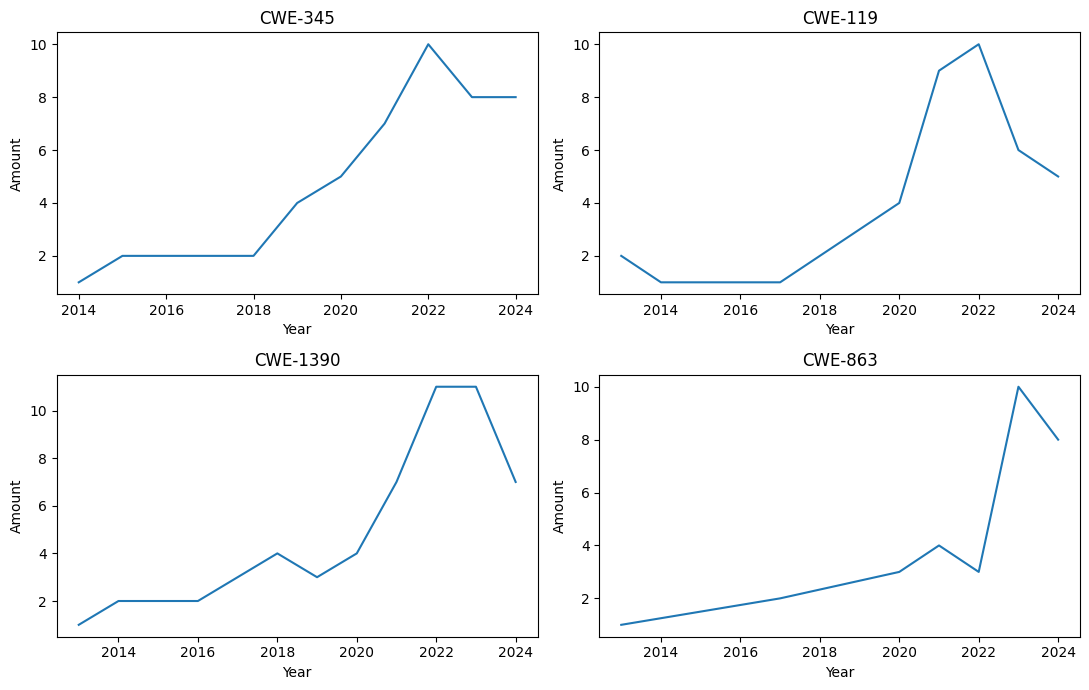

In [121]:
fig,axes = plt.subplots(nrows=2, ncols=2,figsize=(11, 7))

for idx, cwe_id in enumerate(possible_to_sample_cwes.select("cwe_id").to_series()):
    print(cwe_id)
    data = vulnerabilities_types_per_year.filter(pl.col("cwe_id") == cwe_id).to_pandas()
    ax = plt.subplot(2, 2, idx+1)
    ax.set_title(cwe_id)
    ax.set_xlabel("Year")
    ax.set_ylabel("Amount")
    ax.plot(data["year"], data["count"], label=cwe_id)
fig.tight_layout()

# data = {'apple': 10, 'orange': 15, 'lemon': 5, 'lime': 20}
# names = list(data.keys())
# values = list(data.values())

# fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
# axs[0].bar(names, values)
# axs[1].scatter(names, values)
# axs[2].plot(names, values)
# fig.suptitle('Categorical Plotting')

In [73]:
code_unit_changes_df.explode("cwe_id").filter(pl.col("cwe_id") == "CWE-369").count()

commit,repo,new_file,patch,code_unit_after_fix,vulnerability_id,cwe_id,old_file,code_unit_before_fix
u32,u32,u32,u32,u32,u32,u32,u32,u32
11,11,11,11,11,11,11,11,11


### Filter out rare cwes

In [118]:
cwes_to_exclude = clustered_cwes.select("cwe_id").explode("cwe_id").to_series().value_counts().sort("count", descending=True).filter(pl.col("count") < 100).select(pl.col("cwe_id")).to_series().to_list()
code_unit_without_rare_cwes = without_duplicates.explode("cwe_id").with_columns(pl.col("cwe_id").replace(VULNERABILITY_TYPES_MAPPING)).filter(pl.col("cwe_id").is_in(cwes_to_exclude).not_()).group_by("vulnerability_id").agg(pl.col("cwe_id"))
print(f"Amount of vulnerabilities without rare cwes: {code_unit_without_rare_cwes.shape[0]}")
print(f"Number of excluded vulnerabilities: {without_duplicates.unique("vulnerability_id").shape[0] - code_unit_without_rare_cwes.shape[0]}")

Amount of vulnerabilities without rare cwes: 1048
Number of excluded vulnerabilities: 597


In [74]:
code_unit_without_rare_cwes.describe()

statistic,vulnerability_id,cwe_id
str,str,f64
"""count""","""1025""",1025.0
"""null_count""","""0""",0.0
"""mean""",null,null
"""std""",null,null
"""min""","""2013-0212""",null
"""25%""",null,null
"""50%""",null,null
"""75%""",null,null
"""max""","""GHSA-w228-rfpx-fhm4""",null


In [109]:
code_unit_without_rare_cwes.unique("vulnerability_id")

vulnerability_id,cwe_id
str,list[str]
"""2018-14505""","[""CWE-20""]"
"""2021-39371""","[""CWE-610"", ""CWE-610"", … ""CWE-610""]"
"""2023-25668""","[""CWE-119""]"
"""2021-33503""","[""CWE-400""]"
"""2019-7539""","[""CWE-74"", ""CWE-74"", ""CWE-74""]"
…,…
"""GHSA-vx3h-qwqw-r2wq""","[""CWE-610""]"
"""2023-47631""","[""CWE-345""]"
"""2023-27494""","[""CWE-79"", ""CWE-79""]"


In [113]:
code_unit_without_rare_cwes.select("cwe_id").explode("cwe_id").unique()

cwe_id
str
"""CWE-1390"""
"""CWE-74"""
"""CWE-200"""
"""CWE-610"""
"""CWE-79"""
…
"""CWE-863"""
"""CWE-119"""
"""CWE-400"""
